<a href="https://colab.research.google.com/github/silasabs/CoherentOptics/blob/main/Jupyter/Carrier%20Recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

# Recuperação de Portadora

Este notebook contém algumas implementações dos principais algoritmos que realizam a recuperação de portadora em receptores ópticos digitais coerentes, com a finalidade de compensar o deslocamento de frequência da portadora e o ruído de fase.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp.core import pulseShape, firFilter, decimate, pnorm
from optic.models.devices import pdmCoherentReceiver, basicLaserModel
from optic.models.channels import linearFiberChannel, awgn
from optic.models.tx import simpleWDMTx
from optic.utils import parameters
from optic.comm.metrics import fastBERcalc
from optic.comm.modulation import grayMapping
from optic.plot import pconst

import scipy.constants as const

import sys
import os

sys.path.append(os.path.abspath( \
    os.path.join(r'/home/silas/Documents/GitHub/CoherentOptics/algorithms/')))

# obtém funções auxiliares
from utils import convmtx

## 6.1 Frequency Recovery

Existem dois efeitos de fase principais que afetam os sistemas ópticos coerentes digitais. O primeiro é um deslocamento de frequência da portadora, o segundo é o ruído de fase.

Assumindo uma detecção coerente intradina, os lasers transmissores e osciladores locais não operam exatamente na mesma frequência, mas exibem um deslocamento que pode atingir a ordem de alguns gigahertz. Após o front-end óptico, esse deslocamento de frequência é traduzido para o domínio elétrico, levando a uma perda completa da referência de fase para o processo de decisão.

Assumindo uma equalização perfeita e demultiplexação de polarização, um sinal equalizado $y[k]$, prejudicado por um deslocamento de frequência, ruído de fase e ruído aditivo, pode ser expresso como:

$$ y[k]=s[k]e^{j(\theta[k]+k2\pi\Delta f T_{s})}+\eta[k]$$

Onde $s[k]$ é o sinal transmitido, $\theta[k]$ é o ruído de fase, $\Delta f$ é o deslocamento de frequência da portadora, $T_s$ é o período do símbolo e $\eta [k]$ é o ruído gaussiano branco aditivo (AWGN). Como o ruído de fase e os deslocamentos de frequência da portadora têm propriedades diferentes, eles são compensados ​​por algoritmos diferentes. Os algoritmos de recuperação de frequência estimam e compensam $\Delta f$ , enquanto os algoritmos de recuperação de fase estimam e compensam $\theta[k]$.

## 4th-Power Method

Um algoritmo eficaz de recuperação de frequência no domínio da frequência é baseado na análise espectral do sinal recebido elevado à 4ª potência. Este algoritmo foi originalmente proposto para ser utilizado em esquemas QPSK, mas também pode ser estendido para constelações M-QAM com uma perda tolerável de desempenho. 

Se os ruídos aditivos e de fase forem desprezados, e $s[k]$ tiver modulação QPSK, o sinal equalizado é dado por:

$$y[k]=e^{j({\frac{\pi}{4}}+m[k]{\frac{\pi}{2}})}e^{j k2\pi\Delta f T_{s}}$$ 

Onde $m[k] = 0, 1, 2, 3$ indica o quadrante do símbolo QPSK $s[k]$. Aumentar $y[k]$ para a 4ª potência produz:

$$(y[k])^{4}=e^{j\pi}e^{j k2\pi(4\Delta f)T_{s}}$$

Podemos observar pela equação acima que a operação de 4ª potência remove a dependência de $s[k]$ e gera um tom de frequência em $4\Delta f$ . O deslocamento de frequência pode então ser estimado calculando esse tom de frequência e dividindo-o por quatro. Isto não se aplica à modulação M-QAM com M > 4. No entanto, o espectro do sinal elevado à 4ª potência ainda tem um pico em $4\Delta f$, já que algumas partições das constelações M-QAM são constelações QPSK.

A estimativa do deslocamento de frequência, $\hat{\Delta f}$ é então obtido como:

$$\hat{\Delta f} = \frac{1}{4}\operatorname*{max}_{f}|FFT{(y[k])^4}|$$

onde $FFT\{·\}$ é a transformada rápida de Fourier e $f$ é o valor espectral máximo. Uma vez obtido $\hat{\Delta f}$, o deslocamento de frequência da portadora pode ser compensado como:

$$z[k] = y[k]e^{-jk2\pi\hat{\Delta f}T_s}$$

Como os mesmos lasers transmissor e oscilador local são usados ​​para gerar e detectar ambos os sinais multiplexados por polarização $s_1[k]$ e $s_2[k]$, os deslocamentos de frequência experimentados pelos sinais desmultiplexados por polarização $y1[k]$ e $y2[k]$ são semelhantes. Portanto, a estimativa de $\Delta f$ pode ser realizada em apenas um dos sinais ($y1[k]$ ou $y2[k]$), enquanto o resultado pode ser usado para corrigir ambos os sinais.

<br>
<center>
    <img src="https://i.postimg.cc/63JTVRrJ/4th-Power-Method.png">
</center>
</br>

In [2]:
def fourthPower(sigRx, Fs):
    """
    
    Compensa o deslocamento de frequência utilizando o método
    de quarta potência.
    
    Args:
        sigRx (np.array): sinal a ser compensado.
        Fs (int): taxa de amostragem.
        plotSpectrum (bool, optional): retorna o espectro do sinal em quarta potência. Defaults to False.

    Returns:
        tuple: 
            - np.array: sinal compensado.
            - float: estimativa do deslocamento de frequência.
    """
    
    try:
        nModes = sigRx.shape[1]
    except IndexError:
        sigRx = sigRx.reshape(len(sigRx), 1)
    
    NFFT     = sigRx.shape[0]
    axisFreq = Fs * np.fft.fftfreq(NFFT)
    
    time = np.arange(0, sigRx.shape[0]) * 1/Fs

    for indMode in range(nModes):
        
        # Elevar a quarta potência e aplica a FFT
        fourth_power = np.fft.fft(sigRx[:, indMode]**4)

        # Inferir o índice de valor máximo na frequência
        indFO = np.argmax(np.abs(fourth_power))
        
        # Obtenha a estimativa do deslocamento de frequência
        indFO = axisFreq[indFO]/4       
        
        # Compense o deslocamento de frequência
        sigRx[:, indMode] *= np.exp(-1j * 2 * np.pi * indFO * time)
        
    return sigRx, indFO

## Viterbi & Viterbi Algorithm

O algoritmo de recuperação de fase mais simples usado em comunicações ópticas é o algoritmo de Viterbi & Viterbi. Esta técnica, desenvolvida para sinais M-PSK, é baseada em elevar um sinal M-PSK à potência M para remover a modulação de dados do sinal recebido. Um sinal M-PSK $s[k]$ é dado por:

$$s[k]=\sqrt{E_{s}}e^{j2m[k]\pi/M+j\pi/M},\ \ \ \,m[k]\in0,1,\cdot\cdot\cdot,M-1$$

Onde $E_s$ é a energia do símbolo. Elevando $s[k]$ à potência M, obtemos:

$$s^{M}[k]=E_{s}^{M/2}e^{j2m[k]\pi+j\pi}$$

$$s^{M}[k]=E_{s}^{M/2}e^{j\pi}$$

Esta operação elimina a modulação de dados de $s[k]$. Na presença de AWGN de ​​média zero $\eta [k]$ com variância $\sigma_{\eta}^2$, e ruído de fase de Wiener multiplicativo $\theta [k]$, o sinal recebido $z[k]$, elevado à potência M, torna-se:

$$\begin{array}{l}{{z^{M}[k]=(s[k]e^{j\theta[k]}+\eta[k])^{M},}}\\ {{}}\\ {{\approx E_{s}^{M/2}e^{j\pi}e^{j M\theta[k]}+\zeta[k]}}\end{array}$$

Onde $\zeta [k]$ é um AWGN de ​​média zero. No algoritmo de Viterbi & Viterbi, a estimativa de $\theta [k]$ é realizada usando um vetor de símbolos para filtrar a influência de $\zeta [k]$. A estimativa de $\theta [k]$ envolve, além do símbolo recebido atual $z[k]$, N símbolos passados ​​e N símbolos futuros, compreendendo um filtro de comprimento L = 2N + 1. Pode ser demonstrado que a estimativa de máxima verossimilhança (ML) de $\theta [k]$, dado $z$, é calculada como:

$$\hat{\theta}_{ML}[k] = \mathcal{max}_{\theta[k]}\left[\mathcal{f}_{\mathbf{z}|\theta[k]}\left(\mathbf{Z}|\theta[k]\right)\right]$$
$$=\,\frac{1}{M}\,\mathrm{arg}\left({{\bf w}_{\mathrm{ML}}^{T}}^{}\cdot{\bf z}\right)-\,\frac{\pi}{M}$$

Onde $\mathrm{w}_{ML}$ é o filtro de máxima verossimilhança. O filtro $\mathrm{w}_{ML}$ apresenta um comportamento parecido com a distribuição laplaciana e pode ser modelado a partir da função abaixo.

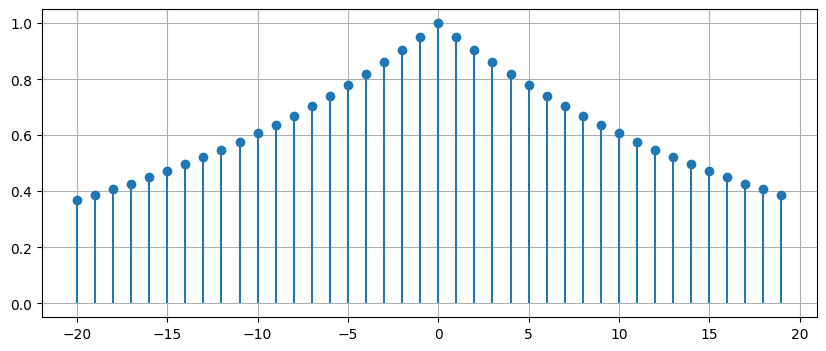

In [3]:
alpha = 0.05
N     = 20
w     = np.arange(-N, N)

plt.figure(figsize=(10, 4))
plt.stem(w, np.exp(-np.abs(w)*alpha), basefmt=' ')
plt.grid()

A ideia é usar uma média móvel da M-ésima potência do sinal recebido para estimar a fase da portadora baseada em uma janela laplaciana para se obter uma estimativa próxima da máxima verossimilhança fazendo a escolha de um $\alpha$ de forma empírica ou optar por uma janela constante, e depois compensar essa fase no sinal recebido.

<br>
<center>
    <img src="https://i.postimg.cc/1RGjKt3t/Screenshot-from-2024-07-24-23-05-21.png">
</center>
</br>

## Filtro de máxima verossimilhança

Outra alternativa é a implementação direta do filtro de máxima verossimilhança (ML) para o algoritmo
Viterbi&Viterbi que depende da relação sinal-ruído e da magnitude do ruído de fase. O comprimento do filtro é dado por $L = 2N + 1$ os coeficientes são obtidos como:

$${\bf w}_{\mathrm{ML}}=({\bf l}^{T}{\bf C}^{-1})^{T}$$

Onde ${\bf l}^{T}$ é um vetor coluna de uns. A matriz de covariância $\bf C$ é dada por:

$${\bf C} = E_{s}^M M^2 \sigma_{\Delta \theta}^2 {\bf K_{LxL}} + E_{s}^M M^{M-1}M^2 \sigma_{\eta}^2 {\bf I_{LxL}}$$

Onde ${\bf I}_{L×L}$ é uma matriz identidade de tamanho $L$ e $E_{s}$ e  a energia do símbolo. A forma de $w_{ML}$ depende do equilíbrio das variâncias de ruído aditivo e multiplicativo $\sigma_{\eta}^2$  e $\sigma_{\Delta \theta}^2$. A matriz ${\bf K}$ pode ser dado como:

$${\bf K} = \begin{bmatrix}
N & \cdots & 2 & 1 & 0 & 0 & 0 & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
2 & \cdots & 2 & 1 & 0 & 0 & 0 & \cdots & 0 \\
1 & \cdots & 1 & 1 & 0 & 0 & 0 & \cdots & 0 \\
0 & \cdots & 0 & 0 & 0 & 0 & 0 & \cdots & 0 \\
0 & \cdots & 0 & 0 & 0 & 1 & 1 & \cdots & 1\\
0 & \cdots & 0 & 0 & 0 & 1 & 2 & \cdots & 2 \\
\vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & 0 & 0 & 0 & 1 & 2 & \cdots & N \\
\end{bmatrix}$$

## Implementação do filtro ML

In [4]:
def mlFilterVV(Es, nModes, OSNRdB, delta_lw, Rs, N, M=4):
    """
    Calcula os coeficientes do filtro de máxima verossimilhança (ML) para o algoritmo 
    Viterbi & Viterbi, que depende da relação sinal-ruído e da magnitude do ruído de fase.

    Parameters
    ----------
    Es : float
        Energia dos símbolos.
    
    nModes : int
        Número de polarizações.

    OSNRdB : float
        OSNR do canal em dB.

    delta_lw : int
        Soma das larguras de linha do laser do oscilador local e transmissor.

    Rs : int
        Taxa de símbolos. [símbolos/segundo]

    N : int
        Número de símbolos passados e futuros na janela. O comprimento
        do filtro é então L = 2*N+1

    M : int, optional
        Ordem do esquema de modulação M-PSK. Defaults to 4.

    Returns
    -------
    np.array
        Coeficientes do filtro de máxima verossimilhança a ser usado em Viterbi & Viterbi.
    
    Referências
    -----------
        [1] Digital Coherent Optical Systems, Architecture and Algorithms

        [2] E. Ip, J.M. Kahn, Feedforward carrier recovery for coherent optical communications. J.
            Lightwave Technol. 25(9), 2675–2692 (2007).
    """
          
    Ts = 1/Rs          # Período de símbolo
    L  = 2 * N + 1     # Comprimento do filtro
    Bref = 12.5e9      # Banda de referência [Hz]
    
    # dB para valor linear
    SNR = 10**(OSNRdB / 10) * (2 * Bref) / (nModes*Rs)
    
    # define a variância do ruído multiplicativo
    σ_deltaTheta = 2 * np.pi * delta_lw * Ts
    
    # define a variância do ruído aditivo
    σ_eta = Es / (2 * SNR)
    
    K = np.zeros((L, L))
    B = np.zeros((N + 1, N + 1))
    
    # Determina a matriz B de forma vetorizada evitando loop nested 
    # e overhead de loops explícitos
    index = np.arange(N + 1)
    B = np.minimum.outer(index, index)
    
    K[:N+1,:N+1] = np.rot90(B, 2)
    K[N:L,N:L] = B
    
    I = np.eye(L)
    
    # Obtém a matriz de covariância
    C = Es**M * M**2 * σ_deltaTheta * K + Es**(M - 1) * M**2 * σ_eta * I
    
    # Determina os coeficientes do filtro 
    h = np.linalg.inv(C) @ np.ones(L)
    
    return h/np.max(h)

## Coeficientes do filtro ML

Quanto menor o OSNR, mais plano o filtro, pois mais símbolos são necessários para filtrar a contribuição do ruído aditivo. Por outro lado, quanto maior o ruído de fase, mais abruptas as bordas do filtro, pois as amostras de ruído de fase nas bordas do filtro são menos correlacionadas com o termo de ruído de fase central. Vamos observar esses comportamentos abaixo obtendo os coeficientes do filtro para cada situação citada anteriormente.

Vamos obter ${\bf w}_{ML} = ({\bf 1}^T {\bf C}^{−1} )^T$ para estimativa de ruído de fase no algoritmo de Viterbi & Viterbi com L = 81 e $\Delta v T_s$ constante = $1 × 10^{−4}$ e OSNR variável. Em seguida iremos variar $\Delta v T_s$ mantendo o OSNR em 10 dB. Assumindo $R_s$ = 28 GBd

In [5]:
# plot figure (a)
N      = 40                      
lw     = 28e5
Rs     = 28e9
Es     = 1
nModes = 2
OSNRdB = [5, 10, 15]

# plot parameters:
colors  = ['g', 'orangered', 'royalblue']
markers = ['D', 's', 'o']

## Figura 6.6 (a)

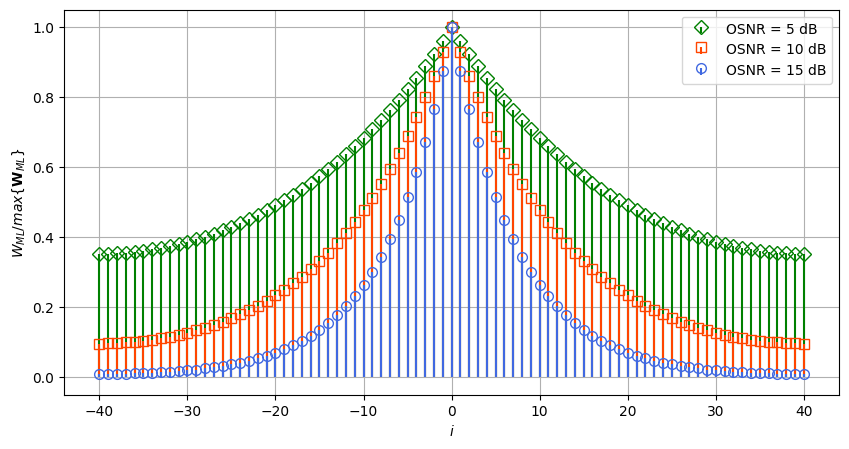

In [6]:
plt.figure(figsize=(10, 5))

for indFigure, color, marker, in zip(OSNRdB, colors, markers):
    
    # obtem os coeficientes ótimos.
    h = mlFilterVV(Es, nModes, indFigure, lw, Rs, N)
    
    # plot os coeficientes.
    markerline = plt.stem(np.arange(-N, N+1), h, linefmt=color, markerfmt=marker, basefmt=' ', \
                          label=f'OSNR = {indFigure} dB')
    
    # remova o preenchimento de cores para os marcadores.
    markerline[0].set_markerfacecolor('none')

    # ajuste o tamanho dos marcadores
    plt.setp(markerline[0], markersize=7) 

plt.xlabel(r'$i$')
plt.ylabel(r'$W_{ML}/max\{{\bf W}_{ML}\}$')
plt.legend()
plt.grid() 

In [7]:
# plot figure (b)
N      = 40                      
lw     = [28e4, 28e5, 28e6]
Rs     = 28e9
Es     = 1
nModes = 2
OSNRdB = 10

# plot parameters:
colors  = ['g', 'orangered', 'royalblue']
markers = ['D', 's', 'o']

## Figura 6.6 (b)

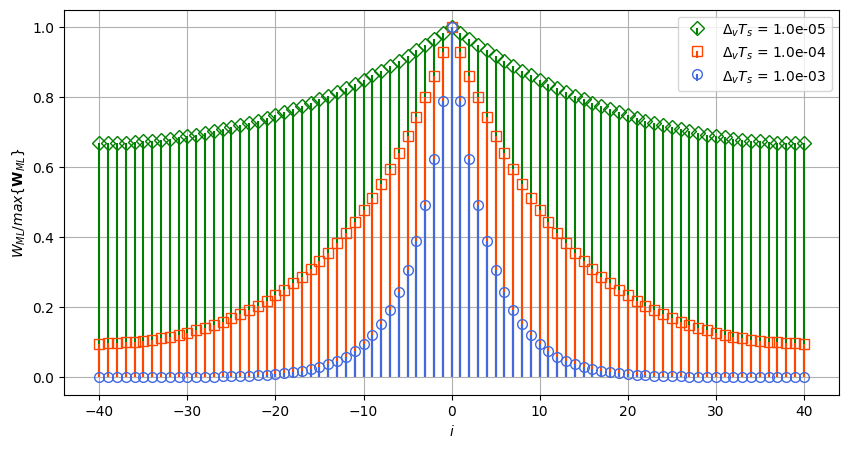

In [15]:
plt.figure(figsize=(10, 5))

for indFigure, color, maker, in zip(lw, colors, markers):

    # obtem os coeficientes ótimos.
    h = mlFilterVV(Es, nModes, OSNRdB, indFigure, Rs, N)
    
    # plot os coeficientes.
    markerline = plt.stem(np.arange(-N, N+1), h, linefmt=color, markerfmt=maker, basefmt=' ', \
                          label=fr'$\Delta_vT_s$ = {(indFigure*1/(Rs)):.1e}')
    
    # remova o preenchimento de cores para os marcadores.
    markerline[0].set_markerfacecolor('none')

    # ajuste o tamanho dos marcadores
    plt.setp(markerline[0], markersize=7)  


plt.xlabel(r'$i$')
plt.ylabel(r'$W_{ML}/max\{{\bf W}_{ML}\}$')
plt.legend()
plt.grid() 

## Implementação de média móvel

In [10]:
def movingAverage(x, N=45, alpha=0.03, H=None, window='constant'):
    """
    Calcula a média móvel para um array 2D ao longo de cada coluna.

    Parameters
    ----------
    x : np.array
        Matriz 2D do tipo (M,N), onde M é a quantidade das amostras
        e N o número de colunas.

    N : int
        Comprimento da janela.

    alpha : float, optional
        Parâmetro de escala (dispersão da distribuição laplaciana), by default 0.03

    H : np.array
        Matriz de coeficientes do filtro de máxima verossimilhança.
    
    window : str, optional
        Define a janela da média móvel [constant, laplacian, viterbi], by default 'constant'

    Returns
    -------
    np.array
        Matriz 2D contendo a média móvel ao longo de cada coluna.
    
    Raises
    ------
    ValueError
        Caso a janela não seja especificada de forma correta.
    
    ValueError
        Caso a janela tenha um comprimento maior que o sinal de entrada.
    """
    
    nModes = x.shape[1]
    
    if window == 'constant':
        h = np.ones(N) / N
    
    elif window == 'laplacian':
        w = np.arange(-N, N)
        h = np.exp(-np.abs(w)*alpha)

    elif window == 'viterbi' and H is not None:
        h = H

    else:
        raise ValueError('Janela especificada incorretamente.')

    if len(h) > x.shape[0]:
        raise ValueError('A janela deve ser menor ou igual ao comprimento do sinal de entrada.')
    
    y = np.zeros(x.shape, dtype=x.dtype)

    for index in range(nModes):
        
        # calcula a média móvel ao longo de cada coluna 
        average = np.convolve(x[:, index], h, mode='same')
        
        # obtém a média móvel ao longo de cada coluna
        y[:, index] = average
        
    return y

## Viterbi & Viterbi (Laplace)

Implementação utilizando uma janela baseada na distribuição de laplace.

In [11]:
def laplaceViterbiCPR(sigRx, alpha=0.03, N=85, M=4):
    """
    Recupera a fase da portadora com o algoritmo Virterbi & Viterbi considerando
    uma janela laplaciana.

    Parameters
    ----------
    sigRx : np.array
        Sinal normalizado em potência, no qual a recuperação de fase será realizada.
    
    alpha : float
        Parâmetro de dispersão da distribuição de Laplace, by default 0.03

    N : int, optional
        Comprimento do filtro, by default 85

    M : int, optional
        Ordem da potência, by default 4

    Returns
    -------
    tuple:
        sigRx (np.array): Constelação com referência de fase.
        phiTime (np.array): Estimativa de fase em cada modo.
    """

    phiTime = np.unwrap(np.angle(movingAverage(sigRx**M, N, alpha, window='laplacian')) / M - np.pi/M, \
                        period=2*np.pi/M, axis=0)
    
    # compensa o ruído de fase
    sigRx = pnorm(sigRx * np.exp(-1j * phiTime))
    
    return sigRx, phiTime

## Viterbi & Viterbi (ML) Moving Average

As implementações abaixo utilizam um filtro de máxima verossimilhança ao contrário da versão anterior onde o filtro e definido pela distribuição de laplace dado por um parâmetro $\alpha$ determinado de manera empírica. Abaixo encontra-se o diagrama dos algoritmos implementados sendo a principal diferença o método de filtragem.

<br>
<center>
    <img src="https://i.postimg.cc/SKkhgxZQ/Screenshot-from-2024-08-10-11-33-54.png">
</center>
</br>

In [12]:
def mlViterbiCPR(sigRx, Rs, OSNRdB, lw, N, M=4):
    """
    Compensa o ruído de fase com o algoritmo Viterbi & Viterbi utilizando 
    média móvel.

    Parameters
    ----------
    sigRx : np.array
        Sinal normalizado em potência, no qual a recuperação de fase será realizada.

    Rs : int   
        Taxa de símbolos. [símbolos/segundo]
        
    OSNRdB : float
        OSNR do canal em dB.

    lw : int
        Soma das larguras de linha do laser do oscilador local e transmissor.
    
    N : int
        Número de símbolos passados e futuros na janela. O comprimento
        do filtro é então L = 2*N+1.

    M : int, optional
        Ordem da potência, by default 4

    Returns
    -------
    tuple:
        sigRx (np.array): Constelação com referência de fase.
        phiTime (np.array): Estimativa do ruído de fase em cada modo.
    """
    
    try:
        nModes = sigRx.shape[1]
    except IndexError:
        sigRx = sigRx.reshape(len(sigRx), 1)
    
    Es = np.mean(np.abs(sigRx) ** 2)
    
    # obtem os coeficientes do filtro de máxima verossimilhança. 
    wML = mlFilterVV(Es, nModes, OSNRdB, lw, Rs, N)

    phiTime = np.unwrap(np.angle(movingAverage(sigRx**M, H=wML, window='viterbi')) / M - np.pi/M, \
                         period=2*np.pi/M, axis=0)
    
    # compensa o ruído de fase
    sigRx = pnorm(sigRx * np.exp(-1j * phiTime))
    
    return sigRx, phiTime

## Viterbi & Viterbi (ML) 

In [13]:
def viterbi(z, lw, Rs, OSNRdB, N, M=4):
    """
    Compensa o ruído de fase com o algoritmo Viterbi & Viterbi.
    
    Parameters
    ----------
    z : np.array
        Sinal normalizado em potência, no qual a recuperação de fase será realizada.
        
    lw : int
        Soma das larguras de linha do laser do oscilador local e transmissor.

    Rs : int
        Taxa de símbolos. [símbolos/segundo].
        
    OSNRdB : float
        OSNR do canal em dB.
        
    N : int
        Número de símbolos passados e futuros na janela. O comprimento
        do filtro é então L = 2*N+1.
        
    M : int, optional
        Ordem da potência, by default 4

    Returns
    -------
    tuple:
        sigRx (np.array): Constelação com referência de fase.
        phiTime (np.array): Estimativa do ruído de fase em cada modo.
    
    Referências
    -----------
        [1] Digital Coherent Optical Systems, Architecture and Algorithms
    """
    
    try:
        nModes = z.shape[1]
    except IndexError:
        z = z.reshape(len(z), 1)
    
    # comprimento do filtro
    L = 2 * N + 1

    Es = np.mean(np.abs(z)**2)

    # obtém os coeficientes do filtro de máxima verossimilhança
    h = mlFilterVV(Es, nModes, OSNRdB, lw, Rs, N)
    
    # estimativa de fase 
    phiTime = np.zeros(z.shape)
    
    for indPhase in range(nModes):
        
        # zero padding
        sigRx = np.pad(z[:, indPhase], (L//2, L//2), mode='constant')
        
        # calcula a matriz de convolução de comprimento L
        sigRx = convmtx(sigRx, L)
        
        # up-down flip
        sigRx = np.flipud(sigRx[:, L-1: -L+1])
        
        # obtém a estimativa de fase em cada modo 
        phiTime[:, indPhase] = np.angle(np.dot(h.T, sigRx**M)) / M - np.pi/M
    
    # phase unwrap
    phiPU = np.unwrap(phiTime, period=2*np.pi/M, axis=0)
    
    # compensa o ruído de fase
    z = pnorm(z * np.exp(-1j * phiPU))
    
    return z, phiPU

## Decision-Directed Algorithm

Os estimadores direcionados à decisão usam decisões para eliminar a dependência das informações transmitidas. No caso da recuperação da fase direcionada à decisão (DD), N decisões de símbolos anteriores são usadas para estimar a realização do ruído de fase $\theta [k]$. A fase estimada $\hat{\theta} [k]$ então compensa a mudança de fase impressa no símbolo recebido $z[k]$.

Embora bastante simples, essa estrutura recursiva tem duas desvantagens principais. Primeiro, o algoritmo requer várias decisões anteriores para estimar a fase atual, o que pode ser um problema para o paralelismo de hardware. Segundo, o algoritmo é baseado em estimativas anteriores de ruído de fase (amostras atuais e futuras não são usadas), introduzindo um erro de previsão que não está presente em soluções de feedforward.

$\hat{\theta}_{ML} [k]$ pode ser dado por:

$$\hat{\theta}_{\mathrm{ML}}[k]=a r g\left(\sum_{i=1}^{N}w_{\mathrm{ML},i}z[k-i]\hat{s}^{*}[k-i]\right)$$

Ao contrário do algoritmo Viterbi & Viterbi, uma vez que apenas símbolos anteriores estão disponíveis para estimar $\theta [k]$, $w_{ML}$ é causal. 

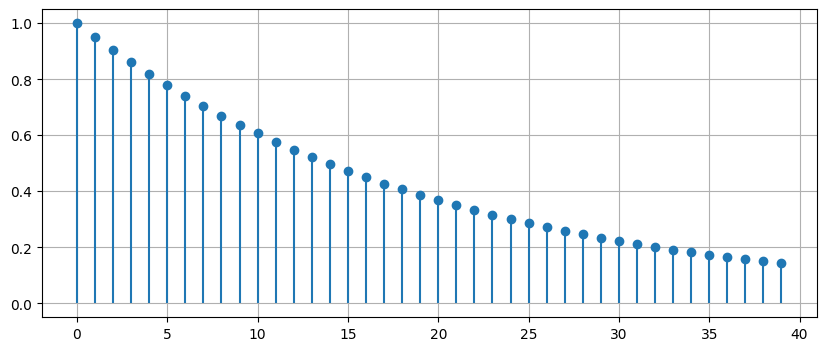

In [14]:
alpha = 0.05
N     = 40
w     = np.arange(0, N)

plt.figure(figsize=(10, 4))
plt.stem(w, np.exp(-np.abs(w)*alpha), basefmt=' ')
plt.grid()

Novamente, quanto menor o OSNR, mais plano o filtro, pois mais símbolos são necessários para filtrar a contribuição do ruído aditivo. Por outro lado, quanto maior o ruído de fase, mais abruptas as bordas do filtro, pois as amostras de ruído de fase são menos correlacionadas. Como etapa final, o ruído de fase é compensado como:

$$v[k] = z[k]e^{-j\hat{\theta}_{ML}[k]}$$

## Teste algoritmos de recuperação de portadora para receptores coerentes

Esta simulação conta com um front-end com deficiências de deslocamento de frequência e ruído de fase, com a finalidade de avaliar os algoritmos implementados para realizar a recuperação de portadora.  

In [15]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                  # order of the modulation format
paramTx.constType = 'qam'       # modulation scheme
paramTx.Rs  = 32e9              # symbol rate [baud]
paramTx.SpS = 16                # samples per symbol
paramTx.pulse = 'rrc'           # pulse shaping filter
paramTx.Ntaps = 4096            # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01         # RRC rolloff
paramTx.Pch_dBm = -2            # power per WDM channel [dBm]
paramTx.Nch     = 1             # number of WDM channels
paramTx.Fc      = 193.1e12      # central optical frequency of the WDM spectrum
paramTx.lw      = 100e3         # laser linewidth in Hz
paramTx.freqSpac = 37.5e9       # WDM grid spacing
paramTx.Nmodes = 2              # number of signal modes [2 for polarization multiplexed signals]
paramTx.Nbits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization

Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

## fiber parameters:
paramFiber = parameters()
paramFiber.L = 100          # comprimento do enlace [km]
paramFiber.alpha = 0        # coeficiente de perdas [dB/Km]
paramFiber.D = 17           # parâmetro de dispersão [ps/nm/km]
paramFiber.Fs = Fs          # Frequência de amostragem do sinal [amostras/segundo]

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

# sigCh = linearFiberChannel(sigWDM_Tx, paramFiber)
SNRdB = 22
sigCh = awgn(sigWDM_Tx, SNRdB, Fs, paramTx.Rs)

  0%|          | 0/1 [00:00<?, ?it/s]

## Front-end sujeito a deslocamento de frequência e ruído de fase

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 100.00 kHz, FO: 60.00 MHz



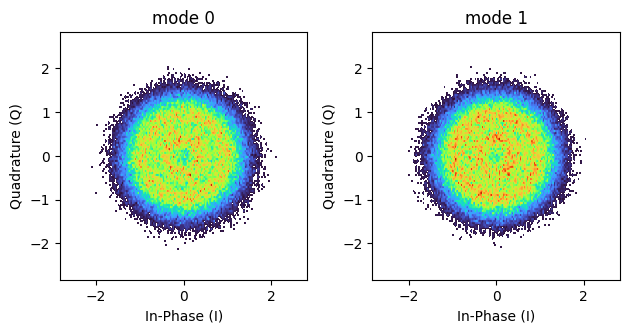

In [16]:
# Receiver

# parameters
chIndex  = 0    # index of the channel to be demodulated

freqGrid = paramTx.freqGrid
π  = np.pi
t  = np.arange(0, len(sigCh))*1/Fs 

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (paramTx.Fc + freqGrid[chIndex])/1e12, const.c/(paramTx.Fc + freqGrid[chIndex])/1e-9))

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 60e6                  # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated

# generate CW laser LO field
paramLO = parameters()
paramLO.P = 10              # power in dBm
paramLO.lw = 100e3          # laser linewidth
paramLO.RIN_var = 0
paramLO.Ns = len(sigCh)
paramLO.Fs = Fs

sigLO = basicLaserModel(paramLO)
sigLO = sigLO*np.exp(1j*2*π*Δf_lo*t) # add frequency offset

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(paramLO.P, paramLO.lw/1e3, FO/1e6))

# polarization multiplexed coherent optical receiver
sigRx = pdmCoherentReceiver(sigCh, sigLO, θsig = 0)

# plot constellation
pconst(sigRx[0::paramTx.SpS,:],R=2);

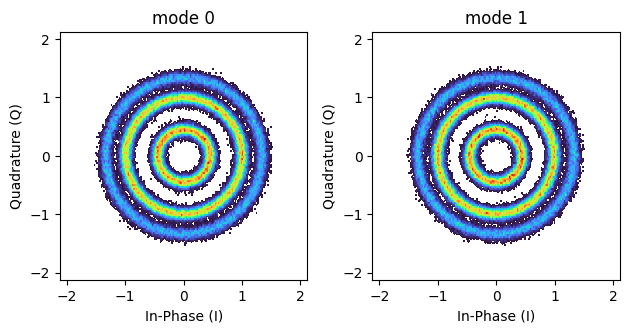

In [17]:
# Rx filtering

# Matched filtering
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
    
pulse = pnorm(pulse)           
sigRx = firFilter(pulse, sigRx)

# decimation
paramDec = parameters()
paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx, paramDec)

pconst(sigRx, R=1.5);

## Recuperação de frequência da portadora com o método de 4th potência

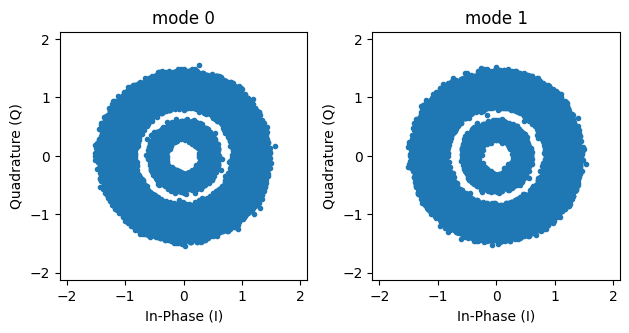

      pol.X      pol.Y      
 SER: 7.44e-01,  7.44e-01
 BER: 3.24e-01,  3.23e-01
 SNR: -0.72 dB,  -0.72 dB


In [18]:
# compensa o deslocamento de frequência
sigRxFOE, indFO = fourthPower(sigRx, Fs)
sigRxFOE = pnorm(sigRxFOE)

# obtém a nova constelação com desvio de frequência compensado
pconst(sigRxFOE, R=1.5, pType='fast')

# Performance metrics
discard = 1000
d = pnorm(symbTx)

ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(sigRxFOE[ind,:], d[ind,:], paramTx.M, paramTx.constType)

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))

## Plot PSD

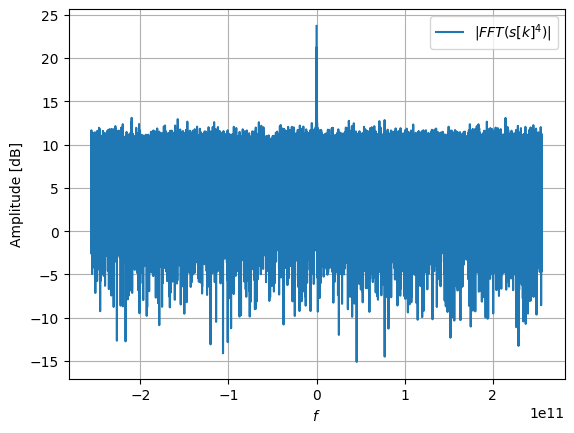

In [19]:
plt.plot(Fs * np.fft.fftfreq(sigRx.shape[0]), 10*np.log10(np.abs(np.fft.fft(sigRx[:, 0]**4))), label=r"$|FFT(s[k]^4)|$")
plt.ylabel('Amplitude [dB]')
plt.xlabel(r'$f$')
plt.legend()
plt.grid()

## Coeficientes do filtro de máxima verossimilhança

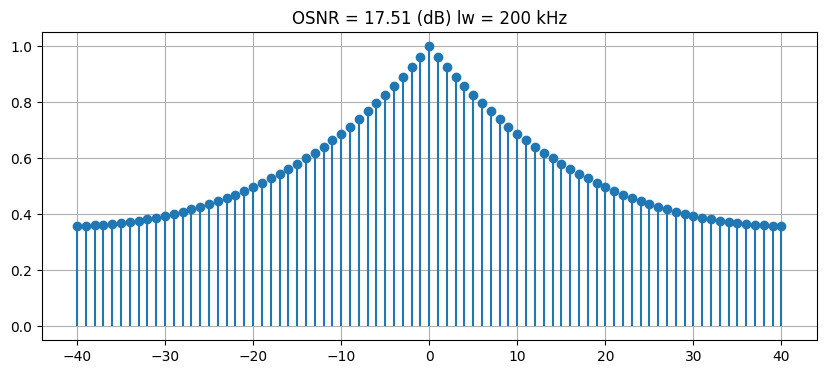

In [20]:
N      = 40                                         # comprimento da janela do filtro
Bref   = 12.5e9                                     # banda de referência [Hz]          
lw     = paramTx.lw + paramLO.lw                    # largura de linha Tx + Rx
OSNRdB = 10 * np.log10(SNRdB * paramTx.Rs / Bref)   # OSNR [dB]
Es     = np.mean(np.abs(sigRxFOE) ** 2)             # energia dos símbolos

# obtem os coeficientes do filtro de máxima verossimilhança
h = mlFilterVV(Es, paramTx.Nmodes, OSNRdB, lw, paramTx.Rs, N)

plt.figure(figsize=(10, 4))
plt.stem(np.arange(-N, N+1), h, basefmt=" ")
plt.title(f'OSNR = {np.round(OSNRdB, 2)} (dB) lw = {int(lw/1e3)} kHz')
plt.grid()

## Recuperação de fase com Viterbi & Viterbi (Moving Average)

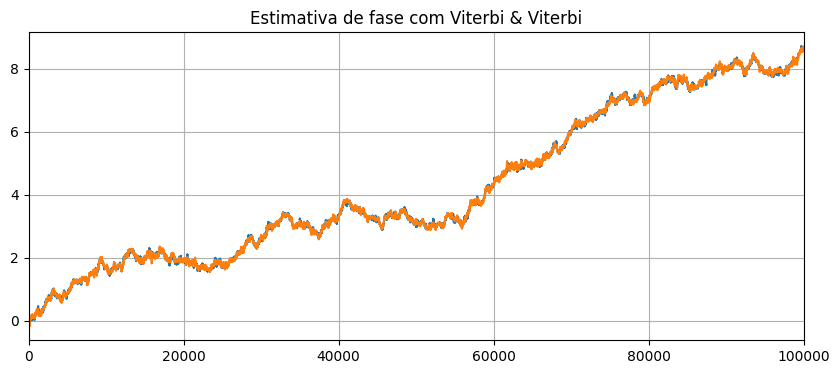

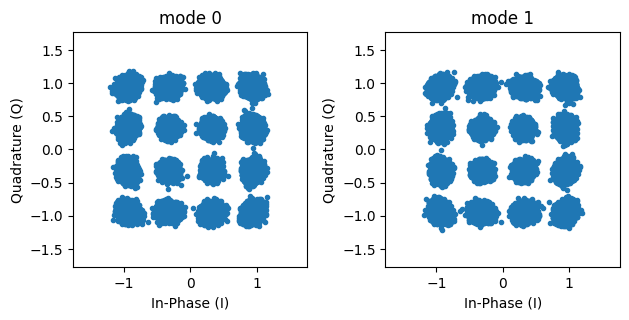

      pol.X      pol.Y      
 SER: 0.00e+00,  1.67e-05
 BER: 0.00e+00,  4.17e-06
 SNR: 21.10 dB,  21.18 dB


In [21]:
# recupera a fase da portadora utilizando o algoritmo de viterbi&viterbi
sigRxCPR, phi = mlViterbiCPR(sigRxFOE, paramTx.Rs, OSNRdB, lw, N)

plt.figure(figsize=(10, 4))
plt.title('Estimativa de fase com Viterbi & Viterbi')
plt.plot(phi, '-')
plt.xlim(0, len(phi))
plt.grid();

discard = 20000

# obtem a nova constelação com referência de fase
pconst(sigRxCPR[discard:], pType='fast')

ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(sigRxCPR[ind,:], d[ind,:], paramTx.M, paramTx.constType)

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))

## Recuperação de fase com Viterbi & Viterbi

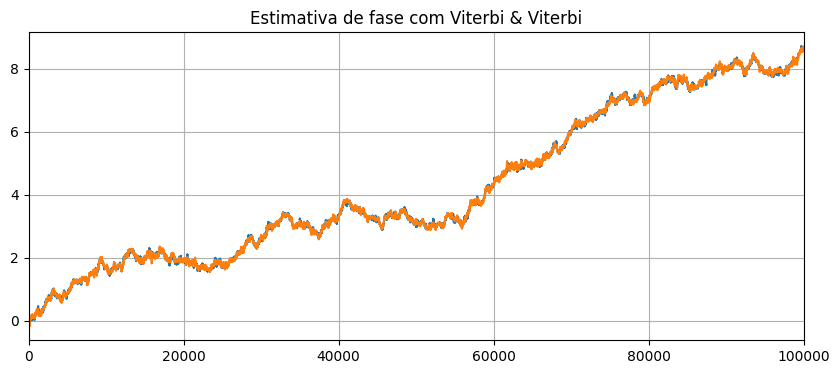

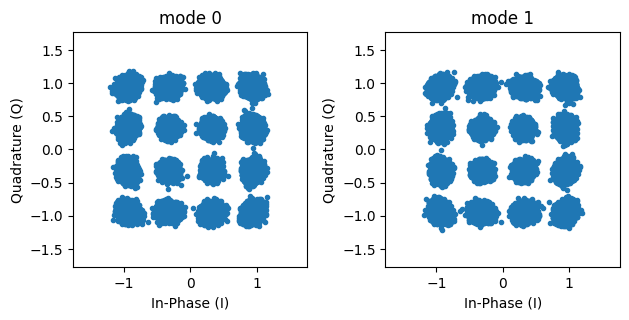

      pol.X      pol.Y      
 SER: 0.00e+00,  1.67e-05
 BER: 0.00e+00,  4.17e-06
 SNR: 21.10 dB,  21.18 dB


In [22]:
# recupera a fase da portadora utilizando o algoritmo de viterbi&viterbi
sigRxCPR, phi = viterbi(sigRxFOE, lw, paramTx.Rs, OSNRdB, N)

plt.figure(figsize=(10, 4))
plt.title('Estimativa de fase com Viterbi & Viterbi')
plt.plot(phi, '-')
plt.xlim(0, len(phi))
plt.grid();

discard = 20000

# obtem a nova constelação com referência de fase
pconst(sigRxCPR[discard:], pType='fast')

ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(sigRxCPR[ind,:], d[ind,:], paramTx.M, paramTx.constType)

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))

# Referências

[1] Digital Coherent Optical Systems, Architecture and Algorithms

[2] E. Ip, J.M. Kahn, Feedforward carrier recovery for coherent optical communications. J. Lightwave Technol. 25(9), 2675–2692 (2007).